In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image = cv2.imread("images/dishes/IMG_8873.JPG")

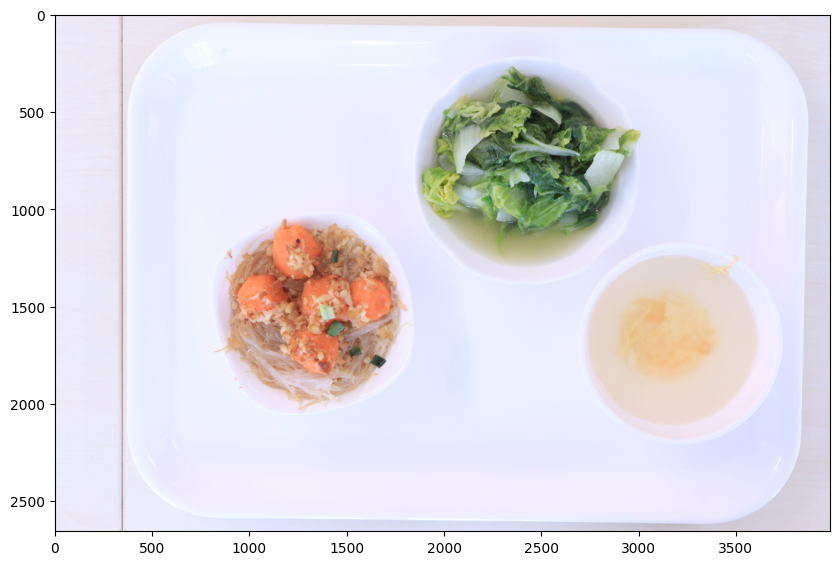

In [3]:
# show original image
plt.figure(figsize=(10, 10))    
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.show()


In [4]:
# image = cv2.resize(image, (0, 0), fx=0.1, fy=0.1)

In [3]:
# # apply gaussian
image = cv2.GaussianBlur(image, (5, 5), 0)

In [4]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # convert to grayscale
# invert the image
gray_image = cv2.bitwise_not(gray_image)


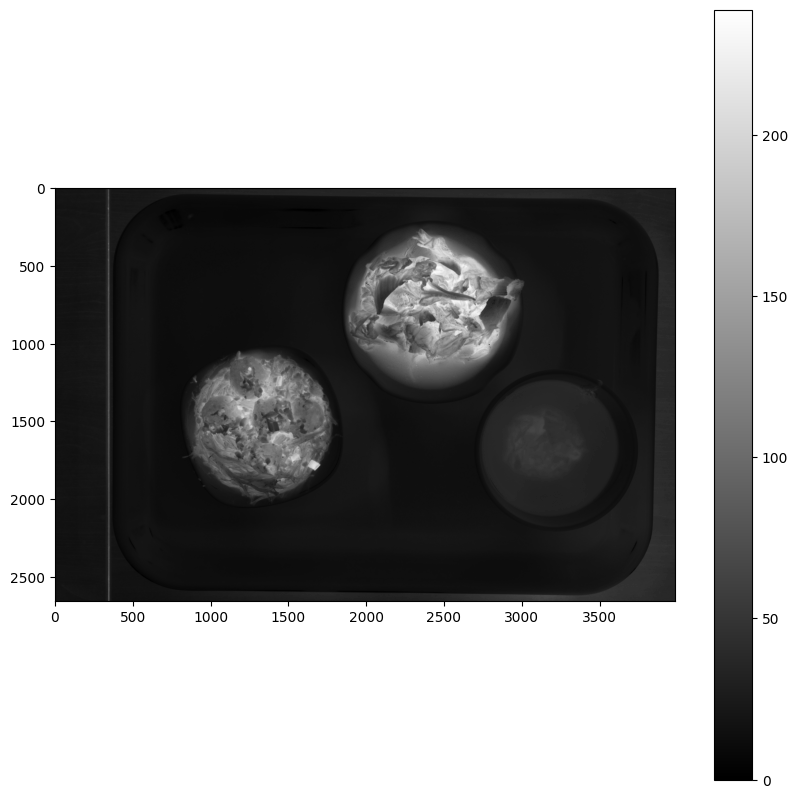

In [5]:
# show image
plt.figure(figsize=(10, 10))
plt.imshow(gray_image, cmap='gray')
# show gray scale colorbar
plt.colorbar()
plt.axis('on')
plt.show()

In [6]:
from skimage import filters
import skimage.measure as measure

In [7]:
# convert the image to float
gray_image = gray_image.astype(float)


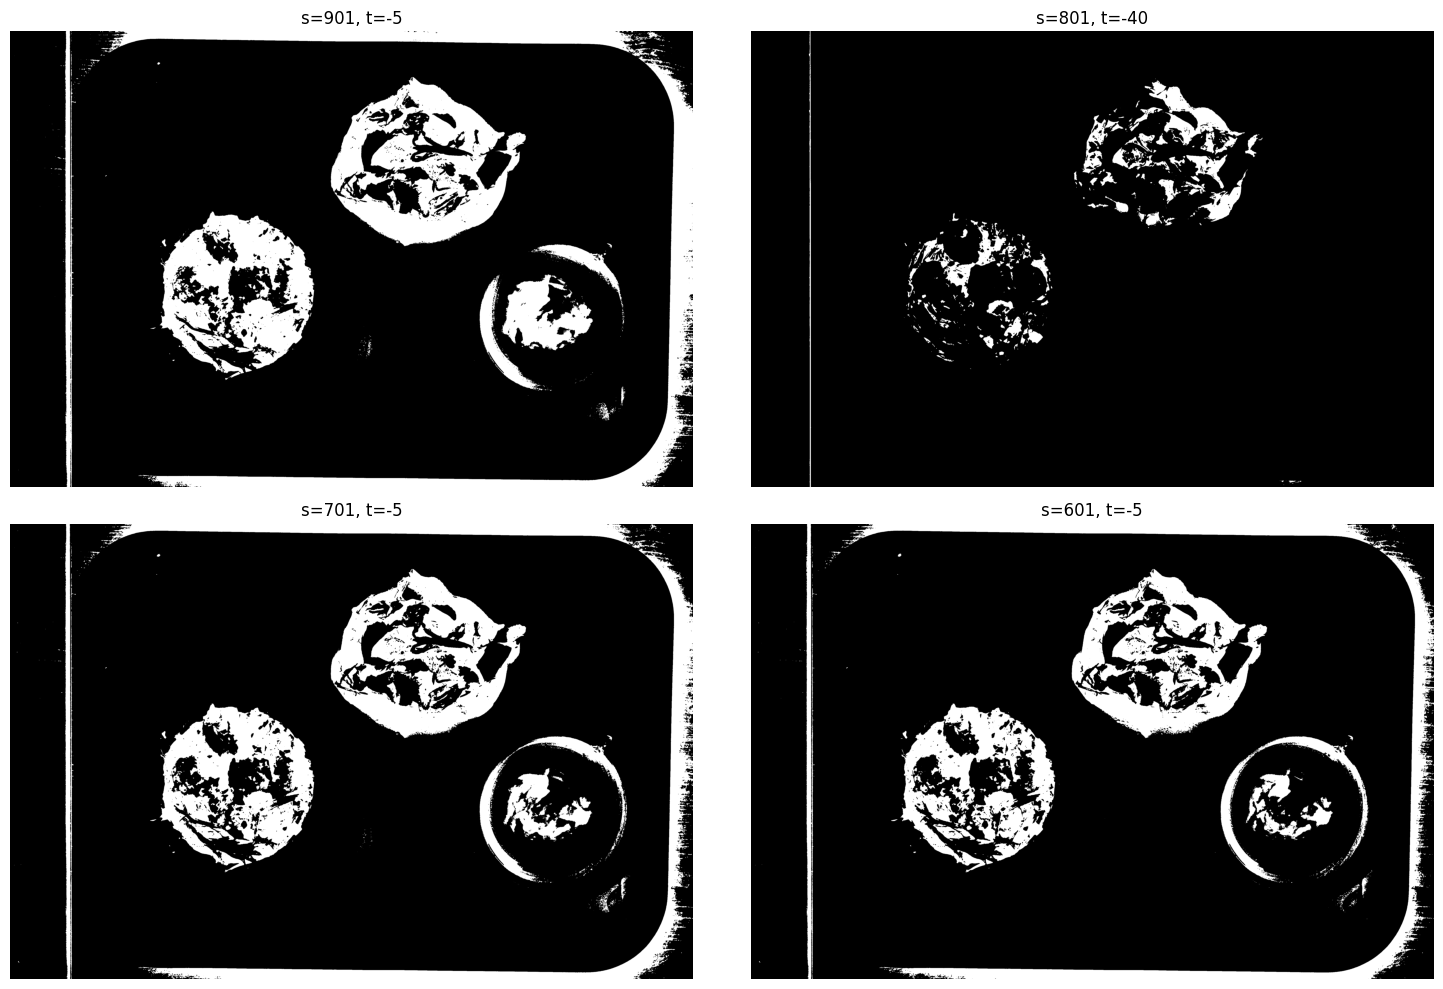

In [12]:
# Define the combinations of s and t
combinations = [(901, -5), (801, -40),(701,-5),(601,-5)]
bina_locals = []
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Iterate through combinations 
for i, (s, t) in enumerate(combinations):
    # Apply the threshold
    local = filters.threshold_local(gray_image, s, offset=t)  
    bina_local = gray_image > local
    
    bina_locals.append(bina_local)


    # Plot the image
    axes[i//2, i%2].imshow(bina_local, cmap='gray')
    axes[i//2, i%2].set_title(f's={s}, t={t}')
    axes[i//2, i%2].axis('off')

plt.tight_layout()
plt.show()

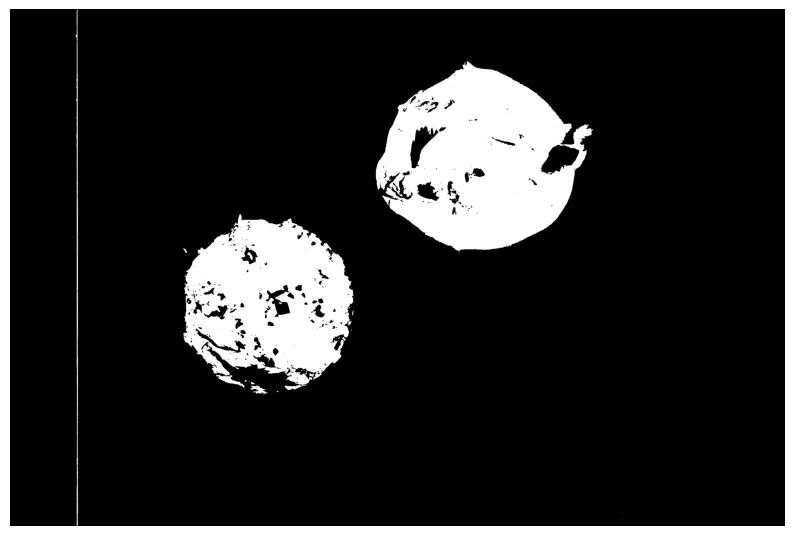

In [8]:
# try otsu's method
threshold = filters.threshold_otsu(gray_image)
bina_otsu = gray_image > threshold

# plot the image
plt.figure(figsize=(10, 10))
plt.imshow(bina_otsu, cmap='gray')
plt.axis('off')
plt.show()


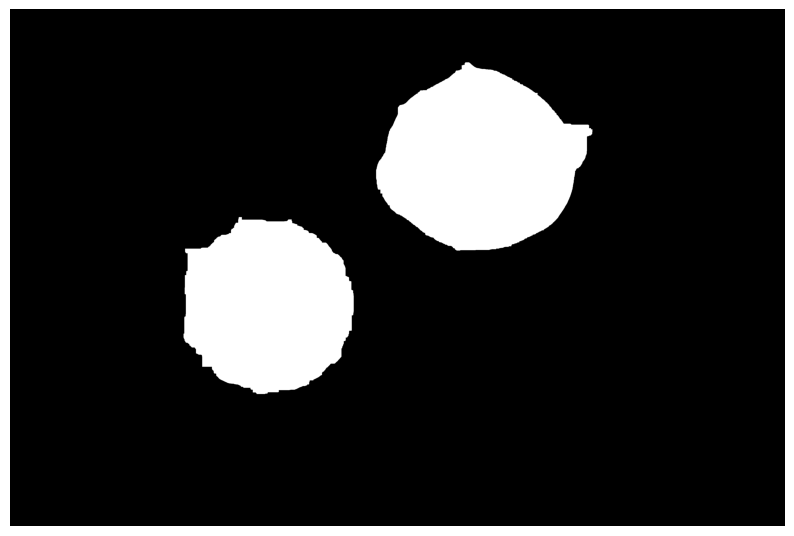

In [9]:
# use closing and opening to remove noise
from cv2 import morphologyEx
# i want all the holes to be filled with a big kernel
kernel = np.ones((90,90), np.uint8)
closing = morphologyEx(bina_otsu.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
# i want all the small noise to be removed with a small kernel
kernel = np.ones((15, 15), np.uint8)
opening = morphologyEx(closing, cv2.MORPH_OPEN, kernel)
# plot the image
plt.figure(figsize=(10, 10))
plt.imshow(opening, cmap='gray')
plt.axis('off')
plt.show()

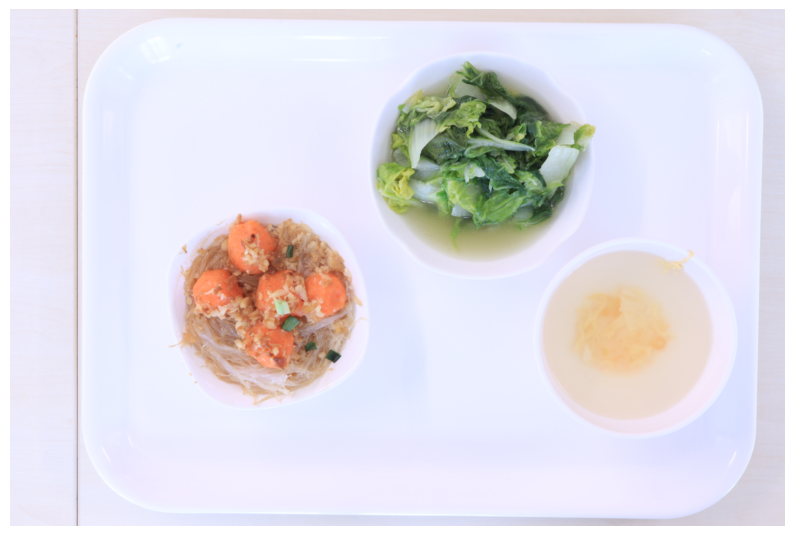

In [10]:
# detect the contours
contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# draw the contours
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# cv2.drawContours(image, contours, -1, (0, 255, 0), 5)
# plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()


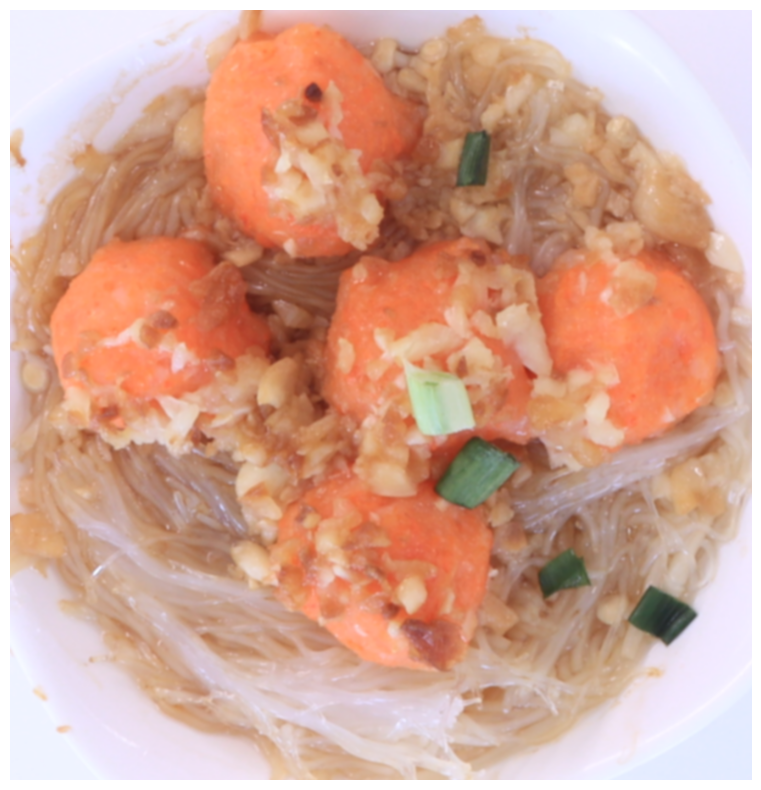

images/dishes/cropped_0.jpg saved


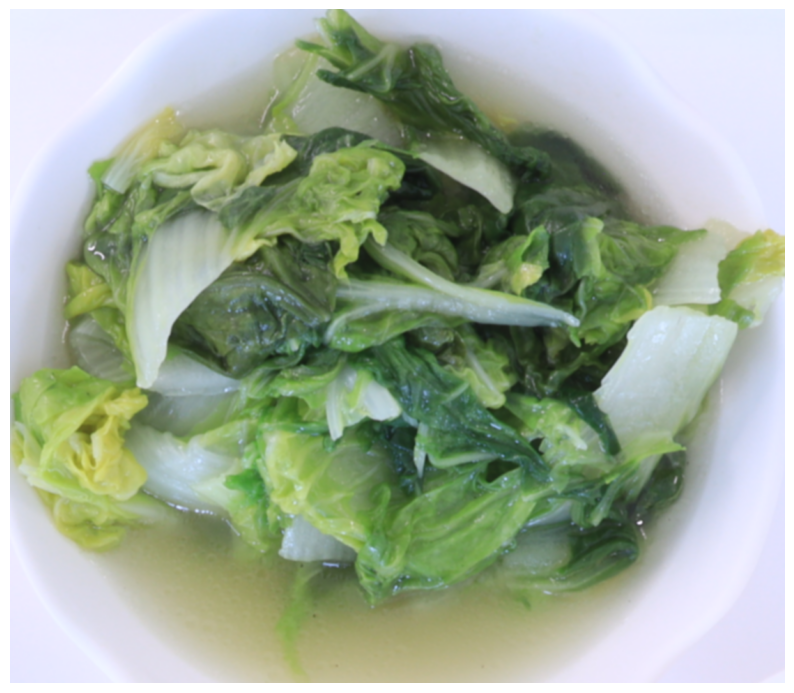

images/dishes/cropped_1.jpg saved


In [11]:
# crop out the image surrounded by contours, store them as seperate images
for i, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    # crop the image
    cropped = image[y:y+h, x:x+w]
    # plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(cropped)
    plt.axis('off')
    plt.show()
    # save the image
    cv2.imwrite(f"images/newly_cropped/cropped_{i}.jpg", cv2.cvtColor(cropped, cv2.COLOR_RGB2BGR))
    print(f"images/dishes/cropped_{i}.jpg saved")



In [11]:
s_values = [601,701,801]
t_values = range(-20,-4)
num_contours_array = np.zeros((len(s_values), len(t_values)))   

for i, s in enumerate(s_values):
    for j, t in enumerate(t_values):
        local = filters.threshold_local(gray_image, s, offset=t)  
        bina_local = gray_image > local
        num_contours = len(measure.find_contours(bina_local, 0.8))
        num_contours_array[i, j] = num_contours

KeyboardInterrupt: 

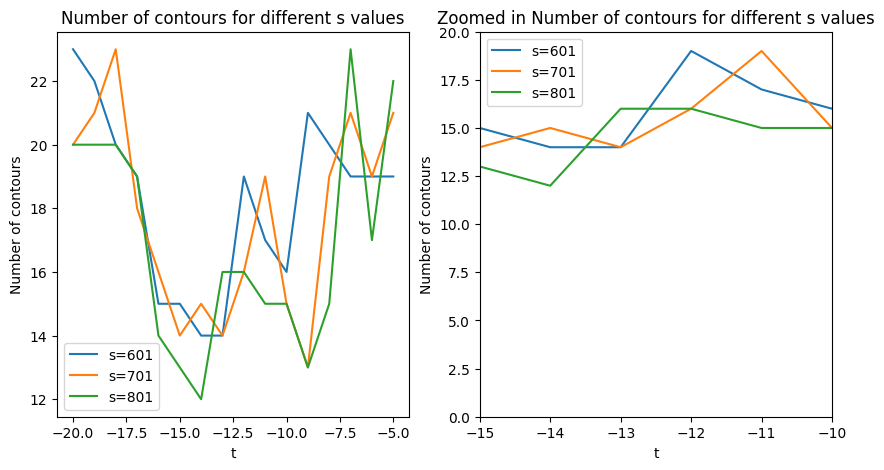

In [ ]:
# plot the curve of three s values
fig = plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
for i, s in enumerate(s_values):
    plt.plot(t_values, num_contours_array[i, :], label=f's={s}')
plt.xlabel('t')
plt.ylabel('Number of contours')
plt.legend()
plt.title('Number of contours for different s values')
plt.subplot(1,2,2)
for i, s in enumerate(s_values):
    plt.plot(t_values, num_contours_array[i, :], label=f's={s}')
plt.xlabel('t')
plt.ylabel('Number of contours')
plt.legend()
plt.title('Zoomed in Number of contours for different s values')
plt.xlim(-15,-10)

plt.ylim(0,20)
plt.show()


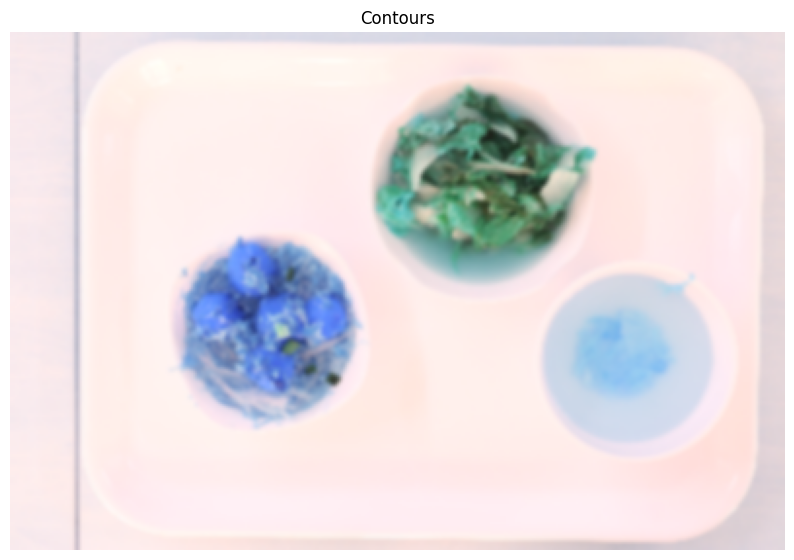

In [ ]:
optimial_s = 801
optimal_t = -11
local = filters.threshold_local(gray_image, optimial_s, offset=optimal_t)
bina_local  = gray_image > local 

contours = measure.find_contours(bina_local, 0.8)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
# for contour in contours:
#     ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.axis('off')
ax.title.set_text('Contours')
plt.show()

[266, 268, 431, 27, 43, 409, 9, 243, 5, 7, 7, 7, 11, 9, 258]


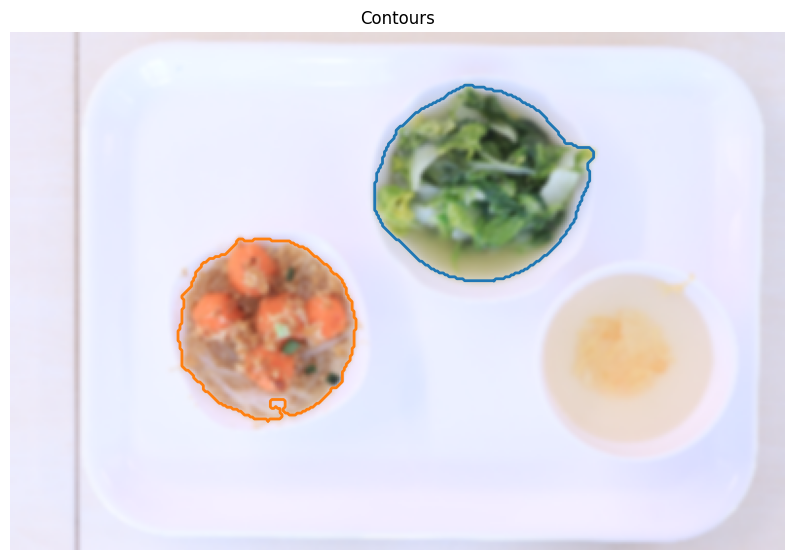

In [ ]:
# now i want to find the area of the contours
areas = []
for contour in contours:
    areas.append(len(contour))

print(areas)
filtered_contours = [contour for contour in contours if len(contour) > 300] 

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
for filtered_contour in filtered_contours:
    ax.plot(filtered_contour[:, 1], filtered_contour[:, 0], linewidth=2)
ax.axis('off')
ax.title.set_text('Contours')
plt.show()

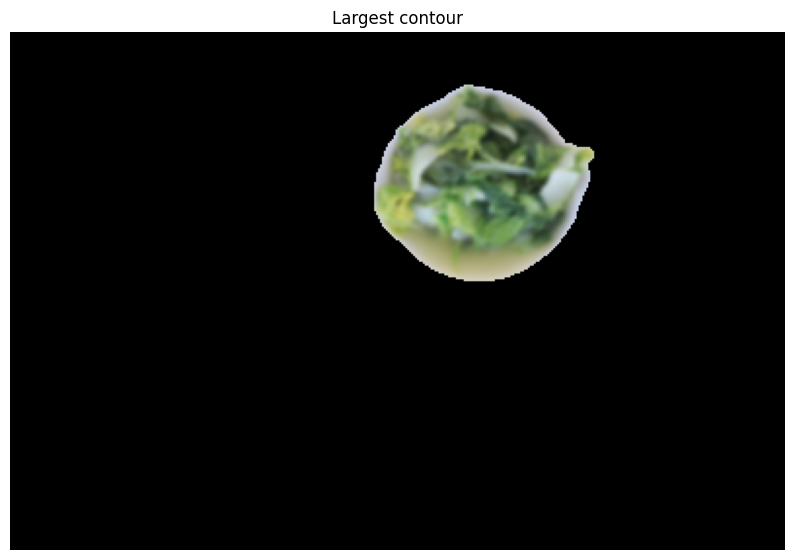

In [ ]:
from skimage.draw import polygon
largest_contour = max(filtered_contours, key=len)   
mask = np.zeros_like(gray_image, dtype=np.bool_)   
rr,cc =  polygon(largest_contour[:, 0], largest_contour[:, 1], mask.shape)
mask[rr,cc] = True
result = np.copy(image)
result[~mask] = 0
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Largest contour')
plt.show()


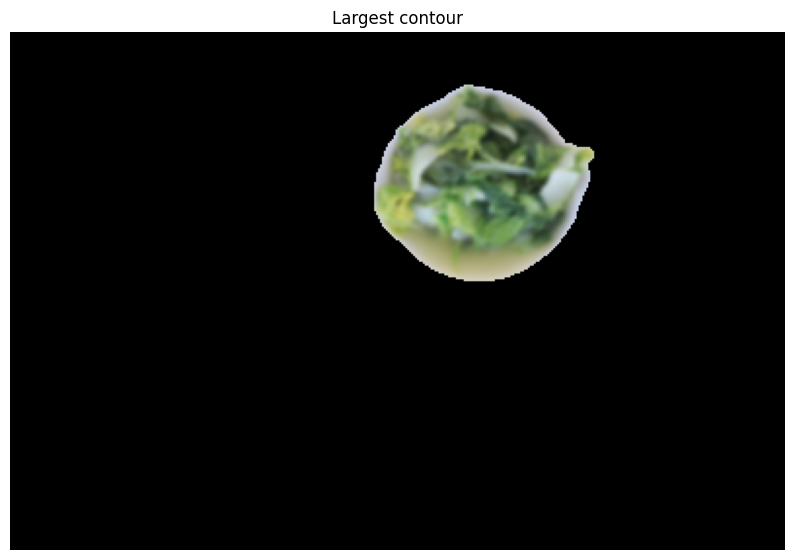

In [ ]:
# only show the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Largest contour')
plt.show()


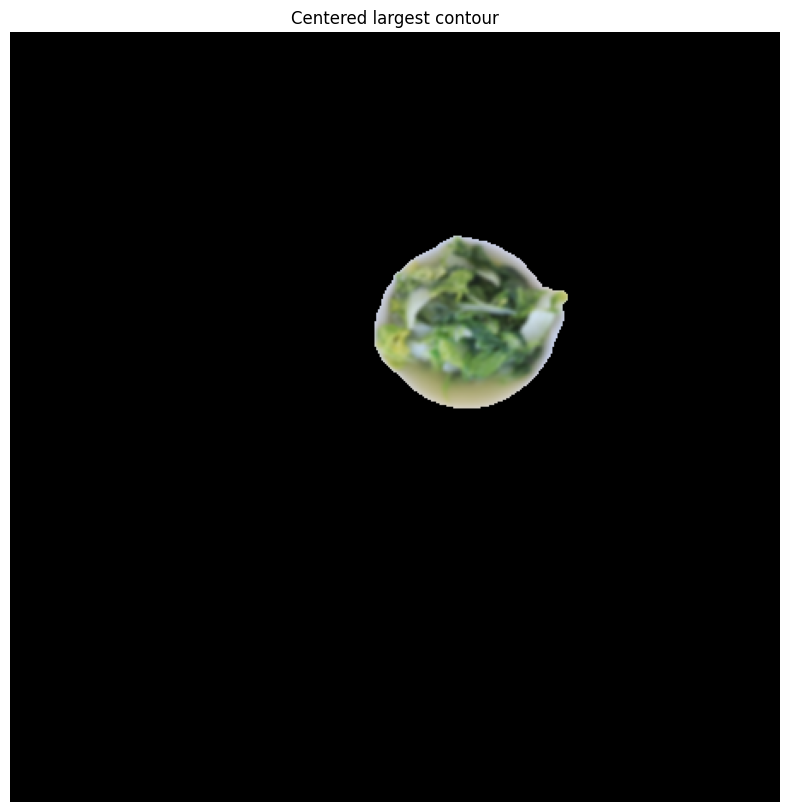

In [ ]:

# Define the fixed canvas size
canvas_size = (450, 450)

# Create a black canvas
canvas = np.zeros((canvas_size[0], canvas_size[1], 3), dtype=np.uint8)

# Calculate the position to paste the result image to center it within the canvas
paste_pos = ((canvas_size[0] - result.shape[0]) // 2, (canvas_size[1] - result.shape[1]) // 2)

# Paste the result image onto the canvas
canvas[paste_pos[0]:paste_pos[0] + result.shape[0], paste_pos[1]:paste_pos[1] + result.shape[1]] = result

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Centered largest contour')
plt.show()


In [ ]:
# now cut off the region of each contour
cut_images = []
for filtered_contour in filtered_contours:
    min_x, max_x = int(np.min(filtered_contour[:, 1])), int(np.max(filtered_contour[:, 1]))
    min_y, max_y = int(np.min(filtered_contour[:, 0])), int(np.max(filtered_contour[:, 0]))
    cut_image = image[min_y:max_y, min_x:max_x]
    cut_images.append(cut_image)


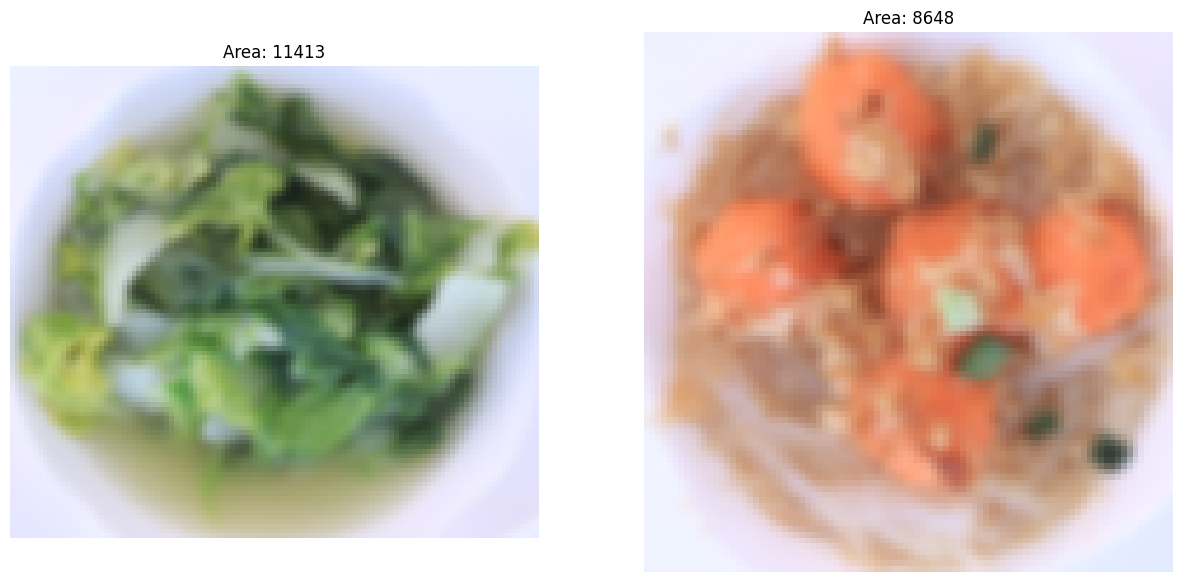

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(cut_images), figsize=(15, 10))
for i, cut_image in enumerate(cut_images):
    axes[i].imshow(cv2.cvtColor(cut_image, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
    axes[i].title.set_text(f'Area: {cut_image.shape[0] * cut_image.shape[1]}')
plt.show()

In [ ]:
# store the cutted images
for i, cut_image in enumerate(cut_images):
    cv2.imwrite(f"images/cutted_dishes/cutted_dish_{i}.jpg", cut_image)
